# Benchmark: Area computation

Benchmark comparing area computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the area of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```bash
cd harness
cargo build --release
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/relwithdebinfo" target/release/benchmark_area --out-file ../analysis/benchmark_area/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data.json
### Statistics: Raw data
                qps            
program         geo        geos
count    110.000000  110.000000
mean      10.231901    1.261647
std        0.261169    0.019653
min        8.507260    1.190689
25%       10.265279    1.257767
50%       10.298709    1.270308
75%       10.329201    1.274771
max       10.385171    1.278673


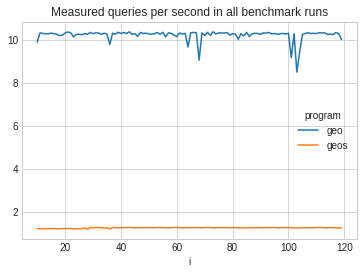

### Statistics: After outlier removal
               qps           
program        geo       geos
count    98.000000  98.000000
mean     10.289585   1.265139
std       0.073788   0.014817
min       9.897458   1.224324
25%      10.272368   1.260434
50%      10.303455   1.270892
75%      10.331243   1.274842
max      10.385171   1.278673


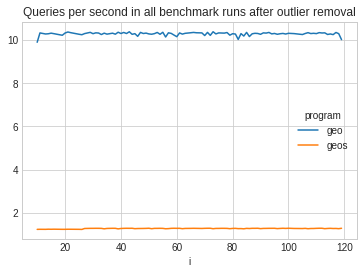

## Ratio of qps compared to geo
               qps
program       geos
count    98.000000
mean      0.122958
std       0.001555
min       0.118841
25%       0.122768
50%       0.123230
75%       0.123739
max       0.127497


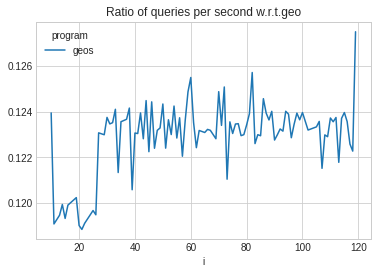

## Ratio of qps compared to geos
               qps
program        geo
count    98.000000
mean      8.134170
std       0.104153
min       7.843349
25%       8.081527
50%       8.114915
75%       8.145429
max       8.414633


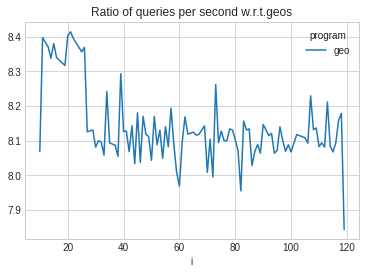

In [1]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 100 -g --call-graph dwarf -o ../analysis/benchmark_area/perf.data -- ./target/release/benchmark_area --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null

cd ../analysis/benchmark_area
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -i perf.data --call-graph=fractal,0.5
```

Observations:
* Over 61% of the time is spent inside `geos::algorithm::Area::ofRingSigned` in libgeos.so - geos area computation proper
  * The descructor `geos::geom::CoordinateArraySequence::~CoordinateArraySequence` in the callgraph is a mystery
* Over 29% of the time is spent inside `geo::algorithm::area::get_linestring_area` -- geo area computation
* geos is *not* slow because of FFI.


# It's the vectors!

Vector iteration is 10x slower than Rust's iterators!

![](./geo_area.png)
![](./geos_area.png)

# Uber-optimized

When building without debug info, gcc -O3 is used. This makes geos faster.

```bash
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/release" target/release/benchmark_area --out-file ../analysis/benchmark_area/data-nodbg.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data-nodbg.json
### Statistics: Raw data
                qps            
program         geo        geos
count    110.000000  110.000000
mean      10.212075    4.502662
std        0.378600    0.104565
min        7.341967    3.768708
25%       10.268325    4.513751
50%       10.304798    4.532483
75%       10.333955    4.547622
max       10.385256    4.569215


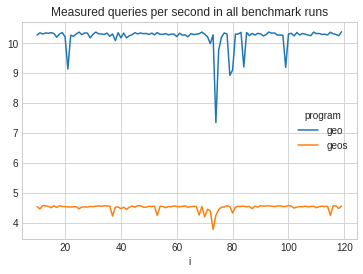

### Statistics: After outlier removal
               qps           
program        geo       geos
count    98.000000  98.000000
mean     10.290620   4.527535
std       0.080152   0.032157
min       9.773720   4.389388
25%      10.273578   4.516781
50%      10.306074   4.535051
75%      10.336065   4.549745
max      10.385256   4.569215


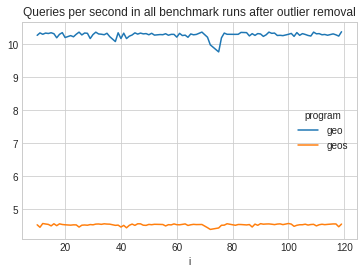

## Ratio of qps compared to geo
               qps
program       geos
count    98.000000
mean      0.439982
std       0.003321
min       0.430000
25%       0.438124
50%       0.440289
75%       0.442216
max       0.453583


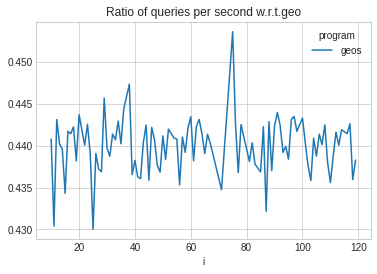

## Ratio of qps compared to geos
               qps
program        geo
count    98.000000
mean      2.272949
std       0.017155
min       2.204667
25%       2.261338
50%       2.271236
75%       2.282460
max       2.325583


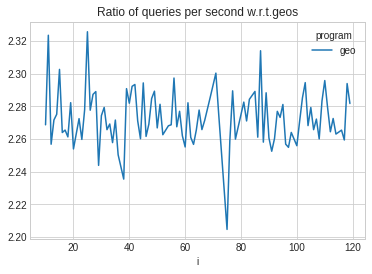

In [2]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data-nodbg.json')
%run ../common/benchmark_analysis.ipynb